In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2
from PIL import Image
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv('public/public.csv')
folderClasses = ['non_globally_sclerotic_glomeruli', 'globally_sclerotic_glomeruli']
df['path'] = df.apply(lambda x: f"public/{folderClasses[x['ground truth']]}/{x['name']}", axis=1)
df.head()

,name,ground truth,path
0,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,public/non_globally_sclerotic_glomeruli/S-2006...
1,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,public/non_globally_sclerotic_glomeruli/S-2006...
2,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,public/non_globally_sclerotic_glomeruli/S-2006...
3,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,public/non_globally_sclerotic_glomeruli/S-2006...
4,S-2006-005094_PAS_1of2_64552732435c92704a3d37d...,0,public/non_globally_sclerotic_glomeruli/S-2006...


In [3]:
def train_validate_test_split(df, split = 0.8, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    split_end = int(split * m)
    train = df.iloc[perm[:split_end]]
    validate = df.iloc[perm[split_end:]]
    train.reset_index(inplace=True)
    train.drop('index', axis=1, inplace=True)
    validate.reset_index(inplace=True)
    validate.drop('index', axis=1, inplace=True)
    return train, validate

train, validate = train_validate_test_split(df, seed=42)

In [4]:
print(f"Train size: {len(train)}")
print(f"Validate size: {len(validate)}")

Train size: 4606
Validate size: 1152


In [5]:
sizes = None
for path in df['path']:
    img = np.asarray(plt.imread(path))
    if sizes is None:
        sizes = [img.shape]
    else:
        sizes.append(img.shape)

widths = [w for h, w, c in sizes]
heights = [h for h, w, c in sizes]

mean_width = round(np.mean(widths))
mean_height = round(np.mean(heights))

In [6]:
class GlomeruliDataset(Dataset):
    folderClasses = ['non_globally_sclerotic_glomeruli', 'globally_sclerotic_glomeruli']
    def __init__(self, df, transform=None):
        self.df = df
        self.labels = df['ground truth'].to_numpy().astype(np.int32)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.labels[idx]
        path = self.df.iloc[idx, 2]
        image = np.asarray(Image.open(path))

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize((mean_width, mean_height)),
    v2.Normalize(mean = [0.5 for _ in range(4)], std = [0.5 for _ in range(4)]),
    v2.ToTensor(),
])

train_dataset = GlomeruliDataset(train, transform=transforms)
validate_dataset = GlomeruliDataset(validate, transform=transforms)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
print(device)

cuda


In [9]:
labels = train_dataset.labels
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
class_weight = 100. / class_sample_count
weights = np.array([class_weight[t] for t in labels])
weights = torch.from_numpy(weights)

In [10]:
class_weight

array([0.02663116, 0.11750881])

In [11]:
sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_dataset), replacement=True)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, sampler=sampler, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
images, labels = next(iter(validate_loader))
print(images.shape)

torch.Size([32, 4, 711, 733])


In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(
            nn.Linear(32 * 21 * 21, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )

        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [14]:
model = SimpleCNN().to(device)
summary(model, (4, mean_width, mean_height), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 354, 365]           1,616
       BatchNorm2d-2         [32, 16, 354, 365]              32
              ReLU-3         [32, 16, 354, 365]               0
         AvgPool2d-4         [32, 16, 177, 182]               0
            Conv2d-5           [32, 32, 88, 90]           4,640
       BatchNorm2d-6           [32, 32, 88, 90]              64
              ReLU-7           [32, 32, 88, 90]               0
         AvgPool2d-8           [32, 32, 44, 45]               0
            Conv2d-9           [32, 32, 42, 43]           9,248
      BatchNorm2d-10           [32, 32, 42, 43]              64
             ReLU-11           [32, 32, 42, 43]               0
        AvgPool2d-12           [32, 32, 21, 21]               0
          Flatten-13                [32, 14112]               0
           Linear-14                  [

In [15]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weight[1], dtype=torch.float64))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [16]:
def train(epoch, model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(loader):
        images, labels = images.float().to(device), labels.float().to(device)
        
        outputs = model(images)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.round(F.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    running_loss /= len(loader)
    accuracy = correct / total * 100
    print(f"Train Epoch {epoch}: Loss {running_loss:.3f},\t Accuracy: {accuracy:.2f}%")
    return running_loss, accuracy

In [17]:
@torch.no_grad()
def validate(epoch, model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for i, (images, labels) in enumerate(loader):
        images, labels = images.float().to(device), labels.float().to(device)
        outputs = model(images)
        outputs.squeeze_()
        loss = criterion(outputs, labels)

        running_loss += loss.item()

        predicted = torch.round(F.sigmoid(outputs))
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    running_loss /= len(loader)
    accuracy = correct / total * 100
    print(f"Validation Epoch {epoch}: Loss {running_loss:.3f},\t Accuracy: {accuracy:.2f}%")
    return y_true, y_pred

In [18]:
torch.cuda.empty_cache()
train_losses = []
train_accuracies = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy = train(epoch, model, train_loader, criterion, optimizer)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
labels, predictions = validate(None, model, validate_loader, criterion)

conf_matrix = confusion_matrix(labels, predictions)
report = classification_report(labels, predictions, target_names=folderClasses)

Train Epoch 0: Loss 0.077,	 Accuracy: 88.06%
Train Epoch 1: Loss 0.038,	 Accuracy: 93.31%
Train Epoch 2: Loss 0.028,	 Accuracy: 95.42%
Train Epoch 3: Loss 0.027,	 Accuracy: 95.38%
Train Epoch 4: Loss 0.020,	 Accuracy: 96.63%
Validation Epoch None: Loss 0.060,	 Accuracy: 95.57%


In [22]:
print(report)

                                  precision    recall  f1-score   support

non_globally_sclerotic_glomeruli       0.98      0.97      0.97       949
    globally_sclerotic_glomeruli       0.87      0.89      0.88       203

                        accuracy                           0.96      1152
                       macro avg       0.92      0.93      0.92      1152
                    weighted avg       0.96      0.96      0.96      1152



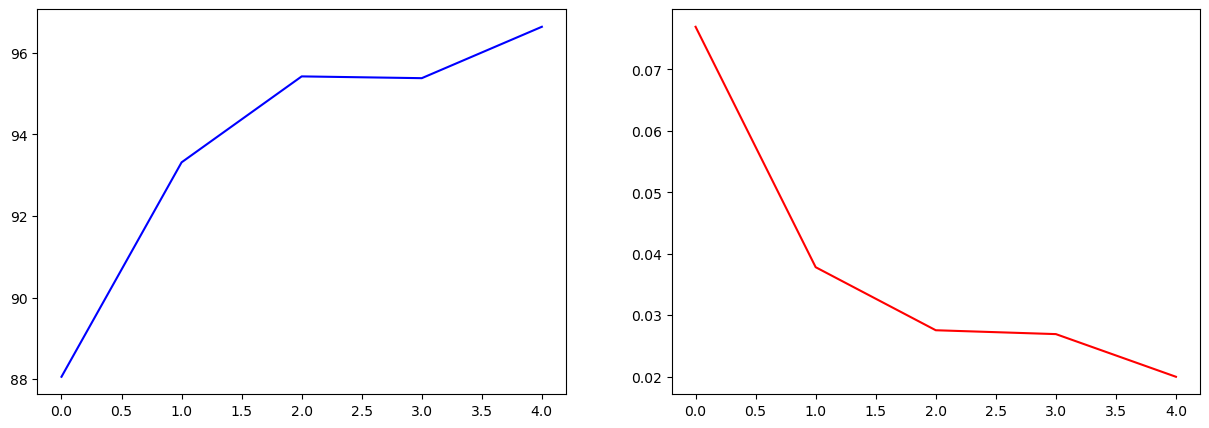

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_accuracies, label='Train Accuracy', color='blue')
ax[1].plot(train_losses, label='Train Loss', color='red')
plt.show()

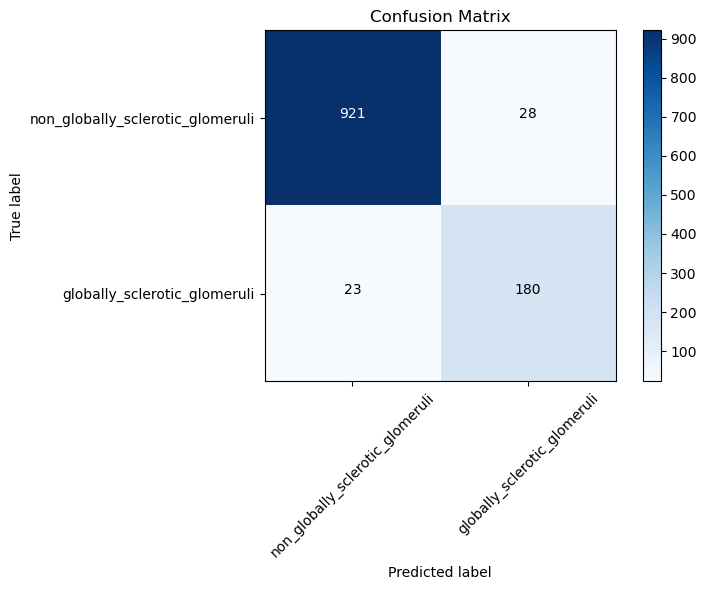

In [20]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(conf_matrix, folderClasses)